##데이터 불러오기

In [ ]:
from google.colab import drive

# 1. Google Drive 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/datathon'
# file_path = f'{data_root}/2019-Nov.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import os

In [ ]:
sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

##구매 빈도가 낮은 고객 분석 → 이탈 징후 탐지 및 리텐션 전략 수립
“구매 빈도가 낮은 고객들의 이탈 징후를 파악하고, 재방문·재구매를 유도할 수 있는 전략 수립"

##EDA - view 파일은 월별로 하나씩 분석 후 결과 누적

In [ ]:
# 카테고리별 조회수 + 유저 수 + PV(유저의 관심도, 탐색도, 노출도를 간접적으로 보여주는 지표) 집계
# 데이터 경로와 파일 목록
months = ['2019-Oct', '2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']
view_summary = []

for month in months:
    file_path = os.path.join(data_root, f"{month}_view.parquet")
    print(f"Processing: {file_path}")

    df = pd.read_parquet(file_path)

    # 필요한 컬럼만 사용 (메모리 절약)
    df = df[['user_id', 'user_session', 'category_lvl1']]
    # 집계
    unique_users = df['user_id'].nunique()
    unique_sessions = df['user_session'].nunique()
    page_views = len(df)

    # 카테고리별 조회수
    category_counts = df['category_lvl1'].value_counts().to_dict()

    # 요약 결과 저장
    view_summary.append({
        'month': month,
        'unique_users': unique_users,
        'unique_sessions': unique_sessions,
        'page_views': page_views,
        'top_categories': category_counts  # 나중에 더 풀어서 저장해도 됨
    })

# 결과 DataFrame
summary_df = pd.DataFrame(view_summary)
summary_df

Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Oct_view.parquet
Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Nov_view.parquet
Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Dec_view.parquet
Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Jan_view.parquet
Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Feb_view.parquet
Processing: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Mar_view.parquet


,month,unique_users,unique_sessions,page_views,top_categories
0,2019-Oct,3022130,9242653,40779399,"{'electronics': 15038390, 'appliances': 479993..."
1,2019-Nov,3695598,13766768,63556110,"{'electronics': 21988192, 'appliances': 803798..."
2,2019-Dec,4576955,15577871,62986067,"{'construction': 16548672, 'appliances': 11078..."
3,2020-Jan,4383932,13757026,52490785,"{'construction': 15094817, 'appliances': 88131..."
4,2020-Feb,4203944,13217465,51232669,"{'construction': 14908750, 'appliances': 79130..."
5,2020-Mar,4107014,12612459,52347910,"{'construction': 13929740, 'appliances': 92207..."


In [ ]:
# 구매 이력 없는 유저 추출 및 마지막 조회 카테고리 확인
# 📅 분석 대상 월
months = ['2019-Oct', '2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']

# Step 1. 전체 구매 유저 목록 수집
purchase_users = set()
for month in months:
    purchase_path = os.path.join(data_root+'/병합 전 event_type 6개월치 분리', f'{month}_purchase.parquet')
    if os.path.exists(purchase_path):
        df_purchase = pd.read_parquet(purchase_path)
        purchase_users.update(df_purchase['user_id'].unique())

print(f'총 구매 유저 수: {len(purchase_users):,}')

# Step 2. 각 view 데이터에서 "구매 경험 없는 유저의 마지막 조회" 추출
last_view_records = []

for month in months:
    view_path = os.path.join(data_root, f'{month}_view.parquet')
    if os.path.exists(view_path):
        print(f"{month} view 파일 처리 중...")
        df_view = pd.read_parquet(view_path)

        # 구매 이력이 없는 유저만 필터링
        df_view = df_view[~df_view['user_id'].isin(purchase_users)].copy()

        # event_time 형 변환
        df_view['event_time'] = pd.to_datetime(df_view['event_time'])

        # 유저별 마지막 조회만 추출
        last_views = df_view.sort_values('event_time').groupby('user_id').tail(1)

        # 필요한 컬럼만 저장
        last_view_records.append(last_views[['user_id', 'event_time', 'category_lvl1']])

# Step 3. 최종 병합
df_last_views = pd.concat(last_view_records, ignore_index=True)
print(f"\n💡 총 '구매 없이 떠난 유저' 수: {df_last_views['user_id'].nunique():,}")

총 구매 유저 수: 1,744,364
2019-Oct view 파일 처리 중...
2019-Nov view 파일 처리 중...
2019-Dec view 파일 처리 중...
2020-Jan view 파일 처리 중...
2020-Feb view 파일 처리 중...
2020-Mar view 파일 처리 중...

💡 총 '구매 없이 떠난 유저' 수: 11,783,595


/tmp/ipython-input-7-200557153.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_last_categories, x='user_count', y='category_lvl1', palette='Blues_d')


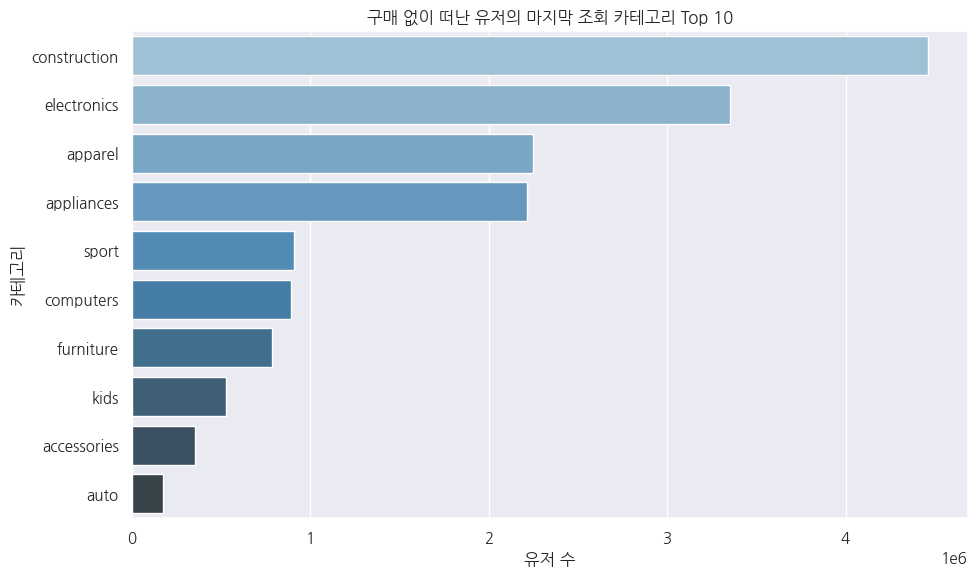

In [ ]:
# 📊 마지막 조회 카테고리 집계
top_last_categories = df_last_views['category_lvl1'].value_counts().head(10).reset_index()
top_last_categories.columns = ['category_lvl1', 'user_count']

# 📈 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=top_last_categories, x='user_count', y='category_lvl1', palette='Blues_d')
plt.title('구매 없이 떠난 유저의 마지막 조회 카테고리 Top 10')
plt.xlabel('유저 수')
plt.ylabel('카테고리')
plt.tight_layout()
plt.show()

In [ ]:
# 구매 경험 없는 유저들의 전체 조회 Top 카테고리 분석
# 구매 이력이 있는 유저 ID 불러오기
df_purchase = pd.read_parquet(data_root +'/purchase_6months.parquet', columns=['user_id'])
months = ['2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']

buyers = set(df_purchase['user_id'].unique())

# view 데이터 중 필요한 컬럼만 선택해서 불러오기
cols = ['user_id', 'category_lvl1']
df_view = pd.read_parquet(data_root+'/2019-Oct_view.parquet', columns=cols)

for month in months:
    temp_df = pd.read_parquet(data_root +f'/{month}_view.parquet', columns=cols)
    df_view = pd.concat([df_view, temp_df], ignore_index=True)

# 구매 경험 없는 유저만 필터링
non_buyer_views = df_view[~df_view['user_id'].isin(buyers)]

# NaN 카테고리 제거 (중요!)
non_buyer_views = non_buyer_views.dropna(subset=['category_lvl1'])

# 카테고리별 전체 조회수 집계
non_buyer_top_categories = non_buyer_views['category_lvl1'].value_counts().reset_index()
non_buyer_top_categories.columns = ['category', 'view_count']

# 결과 출력
print("구매 경험 없는 유저들의 전체 조회 Top 카테고리")
print(non_buyer_top_categories.head(10))

KeyboardInterrupt: 

/tmp/ipython-input-9-163495023.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=non_buyer_top_categories.head(10), x='view_count', y='category', palette='viridis')


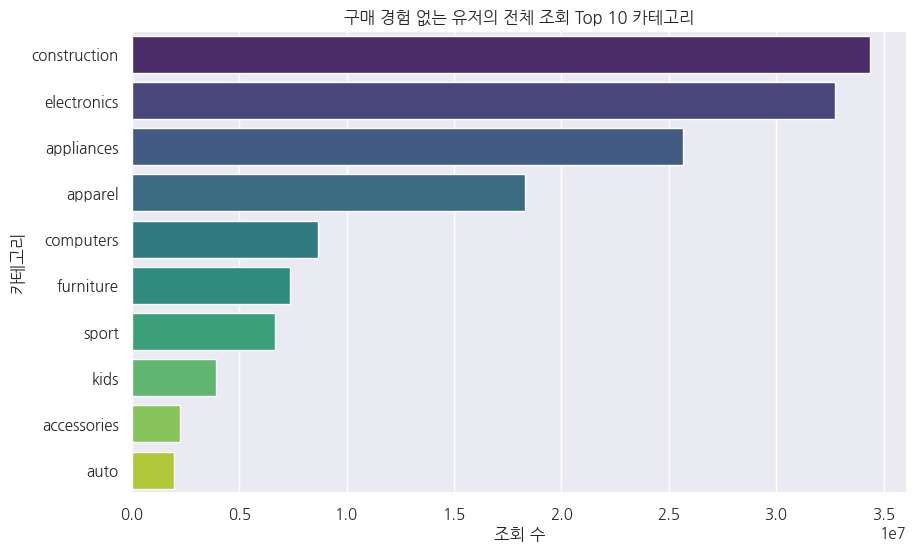

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=non_buyer_top_categories.head(10), x='view_count', y='category', palette='viridis')
plt.title('구매 경험 없는 유저의 전체 조회 Top 10 카테고리')
plt.xlabel('조회 수')
plt.ylabel('카테고리')
plt.show()

1. construction, electronics, apparel, appliances, computers 등 -> 이탈 고객 리타겟팅, 배너 추천, 메일링 전략 수립 가능
2. 구매로 이어지지 않은 관심 카테고리:
마케팅 타겟(리마케팅 or 추천 제품 제안) 우선순위 결정에 활용
전환 유도 위해 필요한 콘텐츠/제품/배너 위치 조정 등에 사용

카테고리별 전환율 계산 및 이탈 위치 파악,
전환율 낮은 (전체 유저 대비 비구매자 비율 높은) 카테고리 분석

In [ ]:
# 파일 경로
cols = ['user_id', 'product_id', 'category_lvl1']

# 1. cart, purchase 데이터 불러오기
df_cart = pd.read_parquet(os.path.join(data_root, 'cart_6months.parquet'), columns=cols)
df_purchase = pd.read_parquet(os.path.join(data_root, 'purchase_6months.parquet'), columns=cols)

# 2. view 데이터 월별로 불러오고 누적 (카테고리별 전환 퍼널용)
months = ['2019-Oct', '2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']
df_view = pd.DataFrame()

for month in months:
    temp = pd.read_parquet(os.path.join(data_root, f'{month}_view.parquet'), columns=cols)
    df_view = pd.concat([df_view, temp], ignore_index=True)

# 3. 결측 제거
df_view = df_view.dropna(subset=['category_lvl1'])
df_cart = df_cart.dropna(subset=['category_lvl1'])
df_purchase = df_purchase.dropna(subset=['category_lvl1'])

# 4. 유저-카테고리 기준으로 각 단계 집계
view_user_cat = df_view.groupby(['user_id', 'category_lvl1']).size().reset_index(name='view_count')
cart_user_cat = df_cart.groupby(['user_id', 'category_lvl1']).size().reset_index(name='cart_count')
purchase_user_cat = df_purchase.groupby(['user_id', 'category_lvl1']).size().reset_index(name='purchase_count')

# 5. 병합 (view 기준)
df_funnel = view_user_cat.merge(cart_user_cat, on=['user_id', 'category_lvl1'], how='left')
df_funnel = df_funnel.merge(purchase_user_cat, on=['user_id', 'category_lvl1'], how='left')

df_funnel.fillna(0, inplace=True)

# 6. 카테고리별 전환율 계산
cat_summary = df_funnel.groupby('category_lvl1').agg({
    'view_count': 'count',  # 유저 수 기준
    'cart_count': lambda x: (x > 0).sum(),
    'purchase_count': lambda x: (x > 0).sum()
}).reset_index()

cat_summary.rename(columns={
    'view_count': 'num_view_users',
    'cart_count': 'num_cart_users',
    'purchase_count': 'num_purchase_users'
}, inplace=True)

# 전환율 계산
cat_summary['view_to_cart_rate'] = cat_summary['num_cart_users'] / cat_summary['num_view_users']
cat_summary['cart_to_purchase_rate'] = cat_summary['num_purchase_users'] / cat_summary['num_cart_users']
cat_summary['view_to_purchase_rate'] = cat_summary['num_purchase_users'] / cat_summary['num_view_users']

# 결과 정렬
cat_summary.sort_values(by='view_to_purchase_rate', ascending=True, inplace=True)

# 결과 출력
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_summary.head(10), x='category_lvl1', y='view_to_purchase_rate')
plt.title("전환율 낮은 Top 10 카테고리 (view → purchase)")
plt.xticks(rotation=45)
plt.ylabel("view → purchase 전환율")
plt.show()

In [ ]:
# 결과 요약 출력
print(cat_summary.head(10))

   category_lvl1  num_view_users  num_cart_users  num_purchase_users  \
12    stationery           51795            2628                 988   
0    accessories          897924           45895               19827   
10      medicine           61564            3325                1600   
6   country_yard          170124           11464                4483   
9           kids         1265189           94089               44806   
3           auto          673542           54242               31551   
4      computers         2076960          191157              100346   
8      furniture         1951497          195569               95914   
1        apparel         3914218          421662              196698   
11         sport         2070396          263477              134566   

    view_to_cart_rate  cart_to_purchase_rate  view_to_purchase_rate  
12           0.050738               0.375951               0.019075  
0            0.051112               0.432008               0.022081

view는 많지만 cart로 잘 넘어가지 않는 카테고리 → 초반 이탈률 ↑

cart에 담기긴 했지만 구매로 이어지지 않는 카테고리 → 결제망설임, 제품신뢰도↓

전환율 낮고 비구매자 비율 높은 카테고리 → 리타겟팅/리마케팅 집중 필요

/tmp/ipython-input-13-3974319759.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


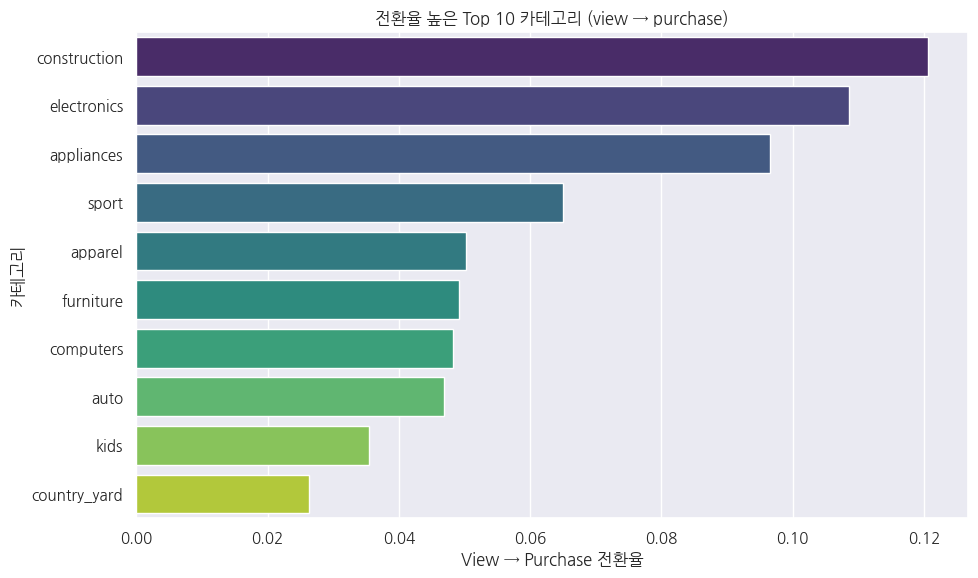

   category_lvl1  num_view_users  num_cart_users  num_purchase_users  \
5   construction         5808522         1188867              700906   
7    electronics         5053141          917944              548398   
2     appliances         3934115          672391              379767   
11         sport         2070396          263477              134566   
1        apparel         3914218          421662              196698   
8      furniture         1951497          195569               95914   
4      computers         2076960          191157              100346   
3           auto          673542           54242               31551   
9           kids         1265189           94089               44806   
6   country_yard          170124           11464                4483   

    view_to_cart_rate  cart_to_purchase_rate  view_to_purchase_rate  
5            0.204676               0.589558               0.120669  
7            0.181658               0.597420               0.108526

In [ ]:
# 전환율 기준 내림차순 정렬
top_conversion = cat_summary.sort_values('view_to_purchase_rate', ascending=False)

# 시각화: View → Purchase 전환율 기준 상위 10개 카테고리
plt.figure(figsize=(10, 6))
sns.barplot(
    x='view_to_purchase_rate',
    y='category_lvl1',
    data=top_conversion.head(10),
    palette='viridis'
)
plt.title('전환율 높은 Top 10 카테고리 (view → purchase)')
plt.xlabel('View → Purchase 전환율')
plt.ylabel('카테고리')
plt.tight_layout()
plt.show()

# 상위 10개 결과 출력
print(top_conversion.head(10))

전환율이 높은 유망 카테고리를 확인 -> 마케팅 집중 타겟이나 재구매 유도 우선순위 결정에도 활용

#카테고리별 리텐션 충족 비율 분석

In [ ]:
# 리텐션 기준 정의
RETENTION_DAYS = 75

# 구매 데이터 불러오기
df_purchase = pd.read_parquet(data_root + '/purchase_6months.parquet')
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# 유저별 첫 구매일 및 이후 구매일
first_purchase = df_purchase.groupby('user_id')['event_time'].min().reset_index().rename(columns={'event_time': 'first_purchase'})
df_purchase = df_purchase.merge(first_purchase, on='user_id')
df_purchase['days_since_first'] = (df_purchase['event_time'] - df_purchase['first_purchase']).dt.days

# 첫 구매는 제외하고, 재구매가 75일 이내에 있었는지 확인
df_purchase['is_repeat'] = df_purchase['days_since_first'] > 0
retention_users = df_purchase[(df_purchase['is_repeat']) & (df_purchase['days_since_first'] <= RETENTION_DAYS)]['user_id'].unique()

# 리텐션 충족 유저 Set
retention_user_set = set(retention_users)

# 첫 구매 시 카테고리 정보로 리텐션율 분석
first_purchases = df_purchase[df_purchase['days_since_first'] == 0][['user_id', 'category_lvl1']]
first_purchases['retained'] = first_purchases['user_id'].apply(lambda x: x in retention_user_set)

# 카테고리별 리텐션 충족률
retention_summary = first_purchases.groupby('category_lvl1')['retained'].agg(['count', 'sum']).reset_index()
retention_summary['retention_rate'] = retention_summary['sum'] / retention_summary['count']

print(retention_summary.sort_values('retention_rate', ascending=False).head(10))

   category_lvl1   count     sum  retention_rate
7    electronics  635693  274155        0.431269
4      computers   76244   32331        0.424046
3           auto   23120    9787        0.423313
10      medicine     919     368        0.400435
12    stationery     745     295        0.395973
0    accessories   11387    4447        0.390533
11         sport   95743   36998        0.386430
6   country_yard    2217     846        0.381597
9           kids   28586   10882        0.380676
1        apparel  136699   50302        0.367976


# 전환율 낮은 카테고리 vs 비구매자 조회 인기 카테고리 비교 시각화

<Figure size 1000x600 with 0 Axes>

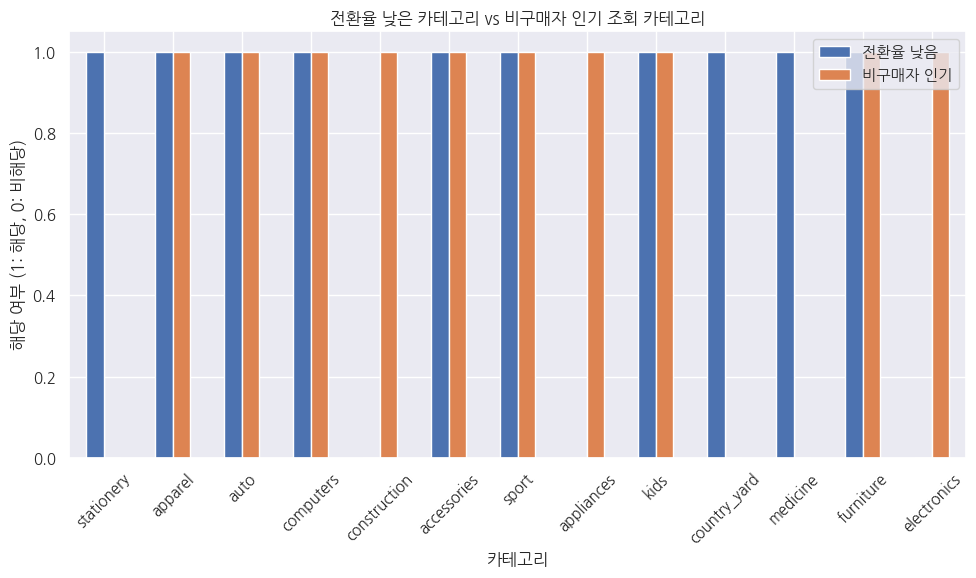

In [ ]:
import matplotlib.pyplot as plt

# 전환율 낮은 Top 10 카테고리
low_conversion_cats = cat_summary.sort_values('view_to_purchase_rate').head(10)['category_lvl1'].tolist()

# 비구매자 Top 10 조회 카테고리
top_non_buyer_cats = non_buyer_top_categories.head(10)['category'].tolist()

# 두 목록 합집합 기준으로 표시
all_cats = list(set(low_conversion_cats + top_non_buyer_cats))

# 비교용 데이터프레임 생성
compare_df = pd.DataFrame({'category': all_cats})
compare_df['low_conversion'] = compare_df['category'].isin(low_conversion_cats)
compare_df['non_buyer_top_view'] = compare_df['category'].isin(top_non_buyer_cats)

# 시각화
plt.figure(figsize=(10, 6))
compare_df.set_index('category')[['low_conversion', 'non_buyer_top_view']].astype(int).plot(
    kind='bar', stacked=False, figsize=(10, 6)
)
plt.title('전환율 낮은 카테고리 vs 비구매자 인기 조회 카테고리')
plt.ylabel('해당 여부 (1: 해당, 0: 비해당)')
plt.xlabel('카테고리')
plt.xticks(rotation=45)
plt.legend(['전환율 낮음', '비구매자 인기'])
plt.tight_layout()
plt.show()

1. apparel, auto, computers, accessories, sport, kids, furniture은 전환율 낮으면서 비구매자들이 많이 본 카테고리 -> 전환 손실이 큰 지점, 개선 시 전환 증대 효과가 클 가능성 -> 상품 설명, 가격, 이미지, 리뷰 등 개선 포인트 있는지 확인 필요, 전환 유도 캠페인(장바구니 할인, 추천 배너, 쿠폰 등) 대상, 비구매자 맞춤 리마케팅 타겟으로 우선 고려
2. stationery, country_yard, medicine 등은 구매까지 이어지는 데 본질적인 진입장벽이 있는 상품군일 수도

| 목적              | 데이터                | 분석 예시                        |
| --------------- | ------------------ | ---------------------------- |
| 전환 가능성 높은 유저 선별 | view만 존재           | 자주 조회하지만 구매 X 유저 → 타겟 마케팅    |
| 인기 카테고리 파악      | view 전체            | 조회 수 기준 Top 10 카테고리 / 시계열 변화 |
| 이탈 징후 분석        | view + purchase    | 구매 없이 떠난 유저의 마지막 조회 카테고리     |
| 구매 전환 경로 파악     | view/cart/purchase | 각 단계 전환율 분석 및 이탈 위치 추정       |

구매 없이 떠난 유저의 마지막 조회 카테고리(이탈 징후 분석), 각 단계 전환율 분석 및 이탈 위치 추정

#카테고리별 결측치에 event_type 분포 확인(결측치 삭제 괜찮은지)

In [ ]:
# 필요한 컬럼 정의 (event_type 추가됨)
view_cols = ['user_id', 'event_time', 'category_lvl1', 'event_type']
cart_cols = ['user_id', 'event_time', 'category_lvl1', 'event_type']
purchase_cols = ['user_id', 'event_time', 'category_lvl1', 'event_type']

# 파일 목록
months = ['2019-Oct', '2019-Nov', '2019-Dec', '2020-Jan', '2020-Feb', '2020-Mar']

# ---------------------
# view 데이터 불러오기
# ---------------------
df_view = pd.DataFrame()
for month in months:
    path = os.path.join(data_root, f"{month}_view.parquet")
    temp = pd.read_parquet(path, columns=view_cols)
    df_view = pd.concat([df_view, temp], ignore_index=True)
print(f"view 데이터 행 수: {len(df_view):,}")

# ---------------------
# cart, purchase 데이터 불러오기
# ---------------------
df_cart = pd.read_parquet(os.path.join(data_root, "cart_6months.parquet"), columns=cart_cols)
df_purchase = pd.read_parquet(os.path.join(data_root, "purchase_6months.parquet"), columns=purchase_cols)

print(f"cart 데이터 행 수: {len(df_cart):,}")
print(f"purchase 데이터 행 수: {len(df_purchase):,}")

view 데이터 행 수: 323,392,940
cart 데이터 행 수: 15,845,463
purchase 데이터 행 수: 5,882,065


In [ ]:
import pandas as pd

# 1. view 데이터 (6개월 분할 파일)에서 필요한 컬럼만 불러와서 병합
view_files = [
    '2019-Oct_view.parquet', '2019-Nov_view.parquet', '2019-Dec_view.parquet',
    '2020-Jan_view.parquet', '2020-Feb_view.parquet', '2020-Mar_view.parquet'
]

cols = ['event_type', 'category_lvl1']
df_view_parts = []

for file in view_files:
    df_temp = pd.read_parquet(os.path.join(data_root, file), columns=cols)
    df_view_parts.append(df_temp)

df_view = pd.concat(df_view_parts, ignore_index=True)

# 2. cart, purchase 데이터 불러오기
df_cart = pd.read_parquet(os.path.join(data_root, 'cart_6months.parquet'), columns=cols)
df_purchase = pd.read_parquet(os.path.join(data_root, 'purchase_6months.parquet'), columns=cols)

# 3. 전체 데이터 병합
df_all = pd.concat([df_view, df_cart, df_purchase], ignore_index=True)

# 4. category_lvl1이 결측치인 행만 추출
df_null = df_all[df_all['category_lvl1'].isnull()]

# 5. 결측치 내 event_type 분포 비율 계산
null_event_dist = df_null['event_type'].value_counts(normalize=True).reset_index()
null_event_dist.columns = ['event_type', 'ratio']

# 6. 출력
print("category_lvl1 결측치 중 event_type 분포:")
print(null_event_dist)

category_lvl1 결측치 중 event_type 분포:
  event_type    ratio
0       view  0.95407
1       cart  0.03409
2   purchase  0.01184


날짜, 시간 분리 파생 컬럼 : 일자별 트렌드, 리텐션, 시계열 그래프 or 시간대별 유입/이탈 분석, 마케팅 시간 설정 가능

In [ ]:
# 정렬
df = df.sort_values(by=['user_id', 'event_time'])

In [ ]:
# 전체 결측치 수 및 비율 확인
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_summary

,Missing Count,Missing %
brand,15341158,13.952755
category_code,35413780,32.208768
category_id,0,0.000000
event_date,0,0.000000
event_hour,0,0.000000
event_time,0,0.000000
event_type,0,0.000000
price,0,0.000000
product_id,0,0.000000
user_id,0,0.000000


In [ ]:
# user_session이 결측치인 행만 필터링
missing_session = df[df['user_session'].isnull()]

# 해당 행들의 event_type 분포 확인 -> cart 라서 빼도 될 듯
missing_session['event_type'].value_counts()

,count
event_type,
cart,12


In [ ]:
top_category_by_segment

# 지연님 여기예요!!!

@@참고@@ 마케팅/실무 관점에서 직관적인 구분, 실제 유통/이커머스 업계 기준을 반영:
7일 이하 → 자주 구매되는 제품 (ex. 식품, 소모품, 생활용품),
30일 이상 → 드물게 구매되는 제품 (ex. 의류, 가전, 계절용품)

@@ 자주 구매되는 제품은 일주일 후 리마인드 메시지, 드물게 구매되는 제품은 한 달 후 리커버리 쿠폰

In [ ]:
# 1. 구매 이벤트만 추출
df_purchase = df[df['event_type'] == 'purchase'].copy()

# 2. 유저별 구매 기록을 시간순 정렬
df_purchase = df_purchase.sort_values(by=['user_id', 'event_time'])

# 3. 다음 구매일 계산 (다음 구매가 없으면 NaT)
df_purchase['next_purchase'] = df_purchase.groupby('user_id')['event_time'].shift(-1)

# 4. 다음 구매까지 걸린 일 수
df_purchase['gap_days'] = (df_purchase['next_purchase'] - df_purchase['event_time']).dt.days

# 5. 다음 구매까지 30일 넘게 걸리거나, 아예 다음 구매가 없는 경우만 필터
mask = (df_purchase['gap_days'].isna()) | (df_purchase['gap_days'] > 30)
no_repurchase_users = df_purchase[mask]['user_id'].unique()

# 6. 결과 출력
print(f'📌 마지막 구매 후 30일 이상 추가 구매가 없는 유저 수: {len(no_repurchase_users):,}명')

In [ ]:
# purchase_6months.parquet 불러오기
df_purchase = pd.read_parquet(os.path.join(data_root, 'purchase_6months.parquet'))
# display(df_purchase.head())

        구매 간격 (일)
count  4137701.00
mean         8.34
std         19.77
min          0.00
25%          0.00
50%          0.00
75%          6.00
90%         27.00
95%         50.00
99%        101.00
max        182.00


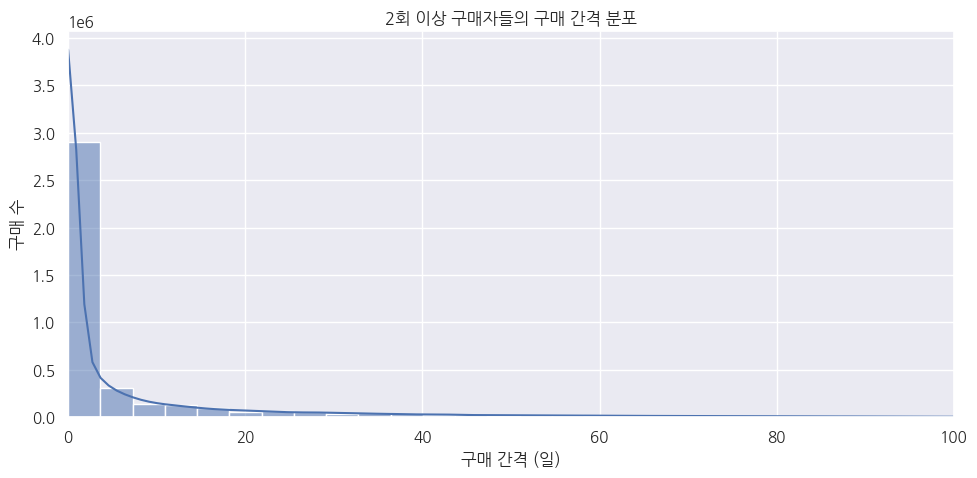

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 날짜 변환 (UTC/비정형 포함)
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'], format='mixed')

# 2. user_id별 구매 횟수
purchase_counts = df_purchase['user_id'].value_counts()

# 3. 2회 이상 구매한 유저만 추출
multi_buyers = purchase_counts[purchase_counts > 1].index
multi_purchase_df = df_purchase[df_purchase['user_id'].isin(multi_buyers)].copy()

# 4. 시간 순 정렬 및 이전 구매일과의 차이 계산
multi_purchase_df = multi_purchase_df.sort_values(by=['user_id', 'event_time'])
multi_purchase_df['prev_event_time'] = multi_purchase_df.groupby('user_id')['event_time'].shift(1)
multi_purchase_df['days_since_prev'] = (multi_purchase_df['event_time'] - multi_purchase_df['prev_event_time']).dt.days

# 5. 유효한 간격만 추출
valid_intervals = multi_purchase_df['days_since_prev'].dropna()

# 6. 통계 요약
interval_summary = valid_intervals.describe(percentiles=[.25, .5, .75, .9, .95, .99]).to_frame(name='구매 간격 (일)').round(2)
print(interval_summary)

# 7. 시각화
plt.figure(figsize=(10, 5))
sns.histplot(valid_intervals, bins=50, kde=True)
plt.title("2회 이상 구매자들의 구매 간격 분포")
plt.xlabel("구매 간격 (일)")
plt.ylabel("구매 수")
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

| 세그먼트 | 기준 (구매 간격, days) | 설명                   |
| ---- | ---------------- | -------------------- |
| 자주   | 0일 \~ 6일 이하      | 75% 이하 고객 포함         |
| 보통   | 7일 \~ 27일 이하     | 상위 15% 포함 (75%\~90%) |
| 드문   | 28일 이상           | 상위 10% 포함 (90% 초과)   |

이유: 75% 고객이 6일 이내 재구매하고, 90%는 27일 이내이므로, 이 구간을 기준으로 세그먼트 나누는 것이 데이터 분포를 잘 반영함.

구매 기간 기준 자주 vs 중간 빈도 vs 드물게

        구매 간격 (일)
count  4137701.00
mean         8.34
std         19.77
min          0.00
25%          0.00
50%          0.00
75%          6.00
90%         27.00
95%         50.00
99%        101.00
max        182.00


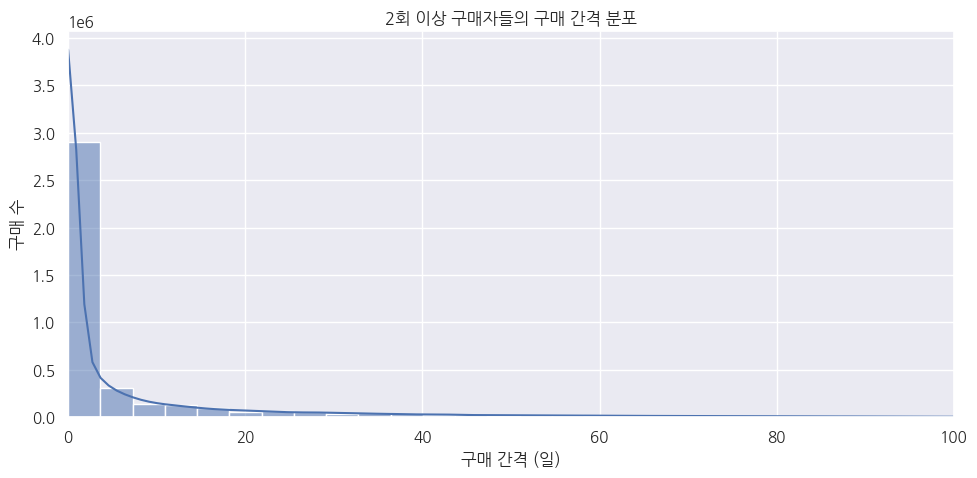

In [ ]:
# 1. 날짜 변환 (UTC/비정형 포함)
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'], format='mixed')

# 2. user_id별 구매 횟수
purchase_counts = df_purchase['user_id'].value_counts()

# 3. 2회 이상 구매한 유저만 추출
multi_buyers = purchase_counts[purchase_counts > 1].index
multi_purchase_df = df_purchase[df_purchase['user_id'].isin(multi_buyers)].copy()

# 4. 시간 순 정렬 및 이전 구매일과의 차이 계산
multi_purchase_df = multi_purchase_df.sort_values(by=['user_id', 'event_time'])
multi_purchase_df['prev_event_time'] = multi_purchase_df.groupby('user_id')['event_time'].shift(1)
multi_purchase_df['days_since_prev'] = (multi_purchase_df['event_time'] - multi_purchase_df['prev_event_time']).dt.days

# 5. 유효한 간격만 추출
valid_intervals = multi_purchase_df['days_since_prev'].dropna()

# 6. 통계 요약
interval_summary = valid_intervals.describe(percentiles=[.25, .5, .75, .9, .95, .99]).to_frame(name='구매 간격 (일)').round(2)
print(interval_summary)

# 7. 시각화
plt.figure(figsize=(10, 5))
sns.histplot(valid_intervals, bins=50, kde=True)
plt.title("2회 이상 구매자들의 구매 간격 분포")
plt.xlabel("구매 간격 (일)")
plt.ylabel("구매 수")
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

| 분위수      | 구매 간격 (일)                                 |
| -------- | ----------------------------------------- |
| Q1 (25%) | 28일 이하        → 전체 고객 중 가장 자주 구매하는 상위 25% |
| Q2 (50%) | 46일 이하        → 중앙값                       |
| Q3 (75%) | 75일 이하        → 전체 고객 중 상위 75% 이내         |

사분위수 기준인데, 여기서 실제 분포와 실무 적용성을 고려해 약간 조정 ↓

| 세그먼트         | 기준 (구매 간격) | 해석 및 활용                 |
| ------------ | ---------- | ----------------------- |
| **자주 구매**    | 0 \~ 30일   | 충성도 높음, 자동 추천·멤버십 혜택 타깃 |
| **중간 빈도 구매** | 31 \~ 75일  | 일반 고객군, 리마인드 알림 대상      |
| **드물게 구매**   | 76일 이상     | 이탈 가능성 ↑, 리텐션 마케팅 타깃    |

| 세그먼트  | 마케팅 전략                            |
| ----- | --------------------------------- |
| 자주 구매 | **우선권 제공**, 할인 알림, 신상품 출시 알림      |
| 중간 구매 | **쿠폰 발송**, 찜한 제품 재입고 알림           |
| 드문 구매 | **이탈 방지용 리마케팅**, 맞춤형 추천, 설문 조사 유도 |


In [ ]:
# 구매 간격 기반 라벨링
def label_by_frequency(days):
    if days <= 30:
        return '자주'
    elif days <= 75:
        return '중간'
    else:
        return '드문'

multi_purchase_df['purchase_segment'] = multi_purchase_df['days_since_prev'].apply(label_by_frequency)

#여기까지입니다!!

<Axes: >

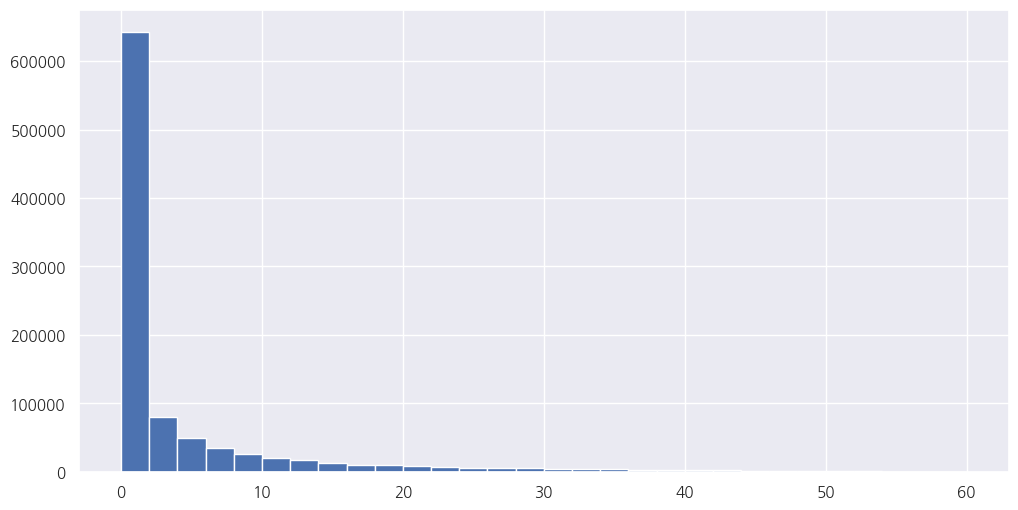

In [ ]:
purchase_df['days_to_next'].dropna().clip(upper=60).hist(bins=30)

In [ ]:
# 6개월치 데이터
df_all = pd.read_csv(f'{data_root}/one_time_buyers_all.csv')

df_all

/tmp/ipython-input-20-3401198785.py:2: DtypeWarning: Columns (9,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(f'{data_root}/one_time_buyers_all.csv')


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,month
0,2019-10-13 13:25:29+00:00,purchase,5100443,2053013553341792533,electronics.clocks,garmin,340.59,303160429,8957377b-66b3-4661-ae91-5c2b5e29fd0e,2019-10-13,13.0,electronics,clocks,NaN,NaN,NaN
1,2019-10-09 15:51:08+00:00,purchase,17301479,2053013553853497655,NaN,NaN,29.89,371877401,d3103132-d38a-4399-9404-f99d03d243d0,2019-10-09,15.0,NaN,NaN,NaN,NaN,NaN
2,2019-10-18 11:19:59+00:00,purchase,2501816,2053013564003713919,appliances.kitchen.oven,artel,41.44,384989212,7472f245-e885-4c5e-b3b1-476a7b19b508,2019-10-18,11.0,appliances,kitchen,oven,NaN,NaN
3,2019-10-26 14:05:39+00:00,purchase,10700971,2053013561277416167,NaN,NaN,20.59,387300134,51d42df3-8ba8-493f-b780-41f09a74be28,2019-10-26,14.0,NaN,NaN,NaN,NaN,NaN
4,2019-10-24 17:54:48+00:00,purchase,12718429,2053013553559896355,NaN,cordiant,48.14,396222093,0ec20848-b6c5-41b5-bba8-132be4461915,2019-10-24,17.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451972,2020-03-31 23:49:41+00:00,purchase,1004835,2232732093077520756,construction.tools.light,samsung,199.87,588488017,84395d1c-4349-49e4-9581-94f63cfb034f,2020-03-31,23.0,construction,tools,light,NaN,2020-03
1451973,2020-03-31 23:54:30+00:00,purchase,100062704,2053013554658804075,electronics.audio.headphone,asus,812.12,624142677,8501ed7e-a926-450e-87ff-da17ce20f14f,2020-03-31,23.0,electronics,audio,headphone,NaN,2020-03
1451974,2020-03-31 23:55:08+00:00,purchase,1003319,2232732093077520756,construction.tools.light,apple,900.64,619860269,ea2efefc-95ea-49ce-9250-fef572c53b44,2020-03-31,23.0,construction,tools,light,NaN,2020-03
1451975,2020-03-31 23:58:19+00:00,purchase,100049773,2232732106860003995,NaN,NaN,234.96,620580925,c33fde42-a5de-4a1f-9e1c-2ac7518a7d41,2020-03-31,23.0,NaN,NaN,NaN,NaN,2020-03


In [ ]:
# 구매 한 번만 한 고객 구하기(6개월치 데이터로 구매 주기 추적 위해)
purchase_df_all = df_all[df_all['event_type'] == 'purchase']

# 고객별 구매 횟수 집계
user_purchase_count = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')

# 정확히 1회만 구매한 유저 필터링
one_time_buyers = user_purchase_count[user_purchase_count['purchase_count'] == 1]

# 결과 출력
print(f'정확히 1회만 구매한 유저 수: {len(one_time_buyers)}명')

정확히 1회만 구매한 유저 수: 1018740명


## 구매 횟수 기준
- 드문 고객: 1회
- 중간 고객: 2~4회
- 빈번 고객: 5회 이상

In [ ]:
# 고객별 총 구매 횟수
user_purchase_freq = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')

In [ ]:
# 고객별 총 구매 횟수의 최소값, 최대값 확인
min_purchase_count = user_purchase_freq['purchase_count'].min()
max_purchase_count = user_purchase_freq['purchase_count'].max()

print(f"최소 구매 횟수: {min_purchase_count}")
print(f"최대 구매 횟수: {max_purchase_count}")

최소 구매 횟수: 1
최대 구매 횟수: 640


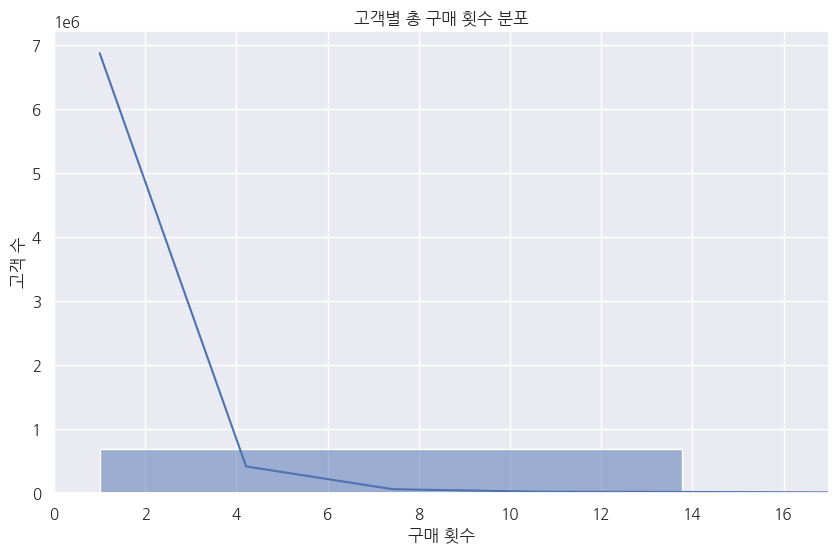

In [ ]:
# 구매 횟수별 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_purchase_freq['purchase_count'], bins=50, kde=True)
plt.title('고객별 총 구매 횟수 분포')
plt.xlabel('구매 횟수')
plt.ylabel('고객 수')
plt.xlim(0, user_purchase_freq['purchase_count'].quantile(0.99)) # 극단치 제외를 위해 99% 분위수까지 표시
plt.show()

| 관찰 결과     | 해석             | 전략 아이디어                 |
| --------- | -------------- | ----------------------- |
| 1회 구매자 다수 | 유입은 되지만 유지 안 됨 | 첫 구매 이후 **리마인드 마케팅 강화** |
| 2\~4회 구매자 | 이탈 직전 가능성      | **충성도 상승 유도 프로모션**      |
| 5회 이상 구매자 | 소수 충성 고객       | **VIP 혜택·추천 제품 제안**     |

In [ ]:
# # N일 이상 이탈 기준 설정 (사용자별 마지막 구매일 이후 n일 이상 구매 없으면 이탈 후보)
# last_purchase = purchase_df.groupby('user_id')['event_time'].max().reset_index()
# last_purchase['days_since_last'] = (pd.to_datetime('2019-12-01') - last_purchase['event_time']).dt.days  # 기준일 예시

# # 30일 이상 이탈 고객
# churned_users = last_purchase[last_purchase['days_since_last'] >= 30]

In [ ]:
# 월별 베스트셀러
purchase_df['event_month'] = purchase_df['event_time'].dt.to_period('M')
monthly_best = purchase_df.groupby(['event_month', 'product_id']).size().reset_index(name='purchase_count')

# 상위 10개 베스트셀러
top_sellers = monthly_best.groupby('event_month').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

In [ ]:
top_sellers = top_sellers.merge(product_df[['product_id', 'product_name']], on='product_id', how='left')


In [ ]:
# 이벤트 유형 분포 확인
df['event_type'].value_counts().plot(kind='bar', title='event.type 분포', figsize=(8,4))
plt.xlabel('event_type'); plt.ylabel('건수')
plt.show()


In [ ]:
# 'purchase' event_type의 건수 확인
purchase_count = df[df['event_type'] == 'purchase'].shape[0]
print(f"구매 (purchase) 이벤트 건수: {purchase_count}")

In [ ]:
# 고객별 첫 구매 ~ 다음 구매 간 시간 간격 계산
purchase_df['next_purchase'] = purchase_df.groupby('user_id')['event_time'].shift(-1)
purchase_df['days_to_next'] = (purchase_df['next_purchase'] - purchase_df['event_time']).dt.days

# 고객별 구매 횟수
purchase_counts = purchase_df.groupby('user_id').size().reset_index(name='purchase_count')

In [ ]:
# 재구매 간격 분포 확인
import matplotlib.pyplot as plt

purchase_df['days_to_next'].dropna().clip(upper=60).hist(bins=30)
plt.title('재구매까지 걸린 일 수 분포 (60일 이상은 클리핑)')
plt.xlabel('Days to Next Purchase')
plt.ylabel('Number of Users')
plt.show()

-> n일 이상 재구매 없으면 이탈이라는 기준 설정 필요

In [ ]:
# 시간대별 사용자 행동
hourly = df.groupby(['event_hour', 'event_type']).size().unstack()
hourly.plot(kind='line', figsize=(10,5), title='시간대별 이벤트 발생량')
plt.xlabel('시간'); plt.ylabel('이벤트 수')
plt.show()


##7개 데이터셋 parquet 파일 만들기+기본 전처리

In [ ]:
10/0

In [ ]:
!pip install pyarrow

In [ ]:
from google.colab import files
import os


# 1회차: 2019-Oct, 2019-Nov
file_names = ['2019-Oct.csv', '2019-Nov.csv']

# 저장 경로 설정
save_path = data_root
os.makedirs(save_path, exist_ok=True)

# 전처리 함수 정의 (공통 처리)
def preprocess(df):
    # event_time 처리
    df['event_time'] = pd.to_datetime(df['event_time'])

    # 날짜, 시간 파생 컬럼
    df['event_date'] = pd.to_datetime(df['event_time'].dt.date)
    df['event_hour'] = df['event_time'].dt.hour

    # category_code 분리
    category_split = df['category_code'].str.split('.', expand=True)
    category_split.columns = ['category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4']
    df = pd.concat([df, category_split], axis=1)

    return df

# 각 CSV 파일 개별 전처리 후 Parquet 저장
for file in file_names:
    print(f"Processing: {file}")

    # CSV 읽기
    df = pd.read_csv(os.path.join(data_root, file))

    # 전처리
    df = preprocess(df)

    # Parquet 파일명 생성
    parquet_file = os.path.join(save_path, file.replace('.csv', '.parquet'))

    # 저장
    df.to_parquet(parquet_file, index=False)
    print(f"Saved: {parquet_file}")


Processing: 2019-Oct.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Oct.parquet
Processing: 2019-Nov.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Nov.parquet


In [ ]:
# 2회차: 2019-Dec, 2020-Jan
file_names = ['2019-Dec.csv', '2020-Jan.csv']

# 저장 경로 설정
save_path = data_root
os.makedirs(save_path, exist_ok=True)

# 전처리 함수 정의 (공통 처리)
def preprocess(df):
    # event_time 처리
    df['event_time'] = pd.to_datetime(df['event_time'])

    # 날짜, 시간 파생 컬럼
    df['event_date'] = pd.to_datetime(df['event_time'].dt.date)
    df['event_hour'] = df['event_time'].dt.hour

    # category_code 분리
    category_split = df['category_code'].str.split('.', expand=True)
    category_split.columns = ['category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4']
    df = pd.concat([df, category_split], axis=1)

    return df

# 각 CSV 파일 개별 전처리 후 Parquet 저장
for file in file_names:
    print(f"Processing: {file}")

    # CSV 읽기
    df = pd.read_csv(os.path.join(data_root, file))

    # 전처리
    df = preprocess(df)

    # Parquet 파일명 생성
    parquet_file = os.path.join(save_path, file.replace('.csv', '.parquet'))

    # 저장
    df.to_parquet(parquet_file, index=False)
    print(f"Saved: {parquet_file}")

Processing: 2019-Dec.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2019-Dec.parquet
Processing: 2020-Jan.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Jan.parquet


In [ ]:
# 3회차: 2020-Feb, 2020-Mar
file_names = ['2020-Feb.csv', '2020-Mar.csv']

# 저장 경로 설정
save_path = data_root
os.makedirs(save_path, exist_ok=True)

# 전처리 함수 정의 (공통 처리)
def preprocess(df):
    # event_time 처리
    df['event_time'] = pd.to_datetime(df['event_time'])

    # 날짜, 시간 파생 컬럼
    df['event_date'] = pd.to_datetime(df['event_time'].dt.date)
    df['event_hour'] = df['event_time'].dt.hour

    # category_code 분리
    category_split = df['category_code'].str.split('.', expand=True)
    category_split.columns = ['category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4']
    df = pd.concat([df, category_split], axis=1)

    return df

# 각 CSV 파일 개별 전처리 후 Parquet 저장
for file in file_names:
    print(f"Processing: {file}")

    # CSV 읽기
    df = pd.read_csv(os.path.join(data_root, file))

    # 전처리
    df = preprocess(df)

    # Parquet 파일명 생성
    parquet_file = os.path.join(save_path, file.replace('.csv', '.parquet'))

    # 저장
    df.to_parquet(parquet_file, index=False)
    print(f"Saved: {parquet_file}")

Processing: 2020-Feb.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Feb.parquet
Processing: 2020-Mar.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Mar.parquet


In [ ]:
# 4월 parquet 파일
# 4회차: 2020-Apr
file_names = ['2020-Apr.csv']

# 저장 경로 설정
save_path = data_root
os.makedirs(save_path, exist_ok=True)

# 전처리 함수 정의 (공통 처리)
def preprocess(df):
    # event_time 처리
    df['event_time'] = pd.to_datetime(df['event_time'])

    # 날짜, 시간 파생 컬럼
    df['event_date'] = pd.to_datetime(df['event_time'].dt.date)
    df['event_hour'] = df['event_time'].dt.hour

    # category_code 분리
    category_split = df['category_code'].str.split('.', expand=True)
    category_split.columns = ['category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4']
    df = pd.concat([df, category_split], axis=1)

    return df

# 각 CSV 파일 개별 전처리 후 Parquet 저장
for file in file_names:
    print(f"Processing: {file}")

    # CSV 읽기
    df = pd.read_csv(os.path.join(data_root+'/원본데이터셋_csv/', file))

    # 전처리
    df = preprocess(df)

    # Parquet 파일명 생성
    parquet_file = os.path.join(save_path, file.replace('.csv', '.parquet'))

    # 저장
    df.to_parquet(parquet_file, index=False)
    print(f"Saved: {parquet_file}")

Processing: 2020-Apr.csv
Saved: /content/drive/MyDrive/Colab Notebooks/datathon/2020-Apr.parquet


##6개 각 view, cart, purchase 나누기(18개 파일)

In [ ]:
import os

# 파일 목록
save_dir = data_root  # 분리 저장할 경로
os.makedirs(save_dir, exist_ok=True)

parquet_files = [
    '2019-Oct.parquet', '2019-Nov.parquet', '2019-Dec.parquet',
    '2020-Jan.parquet', '2020-Feb.parquet', '2020-Mar.parquet'
]

# 하나씩 처리
for fname in parquet_files:
    path = os.path.join(data_root, fname)
    print(f"Reading: {fname}")
    df = pd.read_parquet(path)

    for etype in df['event_type'].unique():
        df_sub = df[df['event_type'] == etype]
        # 저장 파일명 예: 2019-Oct_view.parquet
        save_name = fname.replace('.parquet', f'_{etype}.parquet')
        df_sub.to_parquet(os.path.join(save_dir, save_name), index=False)
        print(f"Saved: {save_name} ({len(df_sub):,} rows)")

Reading: 2019-Oct.parquet
Saved: 2019-Oct_view.parquet (40,779,399 rows)
Saved: 2019-Oct_purchase.parquet (742,849 rows)
Saved: 2019-Oct_cart.parquet (926,516 rows)
Reading: 2019-Nov.parquet
Saved: 2019-Nov_view.parquet (63,556,110 rows)
Saved: 2019-Nov_cart.parquet (3,028,930 rows)
Saved: 2019-Nov_purchase.parquet (916,939 rows)
Reading: 2019-Dec.parquet
Saved: 2019-Dec_view.parquet (62,986,067 rows)
Saved: 2019-Dec_purchase.parquet (1,162,048 rows)
Saved: 2019-Dec_cart.parquet (3,394,763 rows)
Reading: 2020-Jan.parquet
Saved: 2020-Jan_view.parquet (52,490,785 rows)
Saved: 2020-Jan_cart.parquet (2,641,249 rows)
Saved: 2020-Jan_purchase.parquet (835,007 rows)
Reading: 2020-Feb.parquet
Saved: 2020-Feb_view.parquet (51,232,669 rows)
Saved: 2020-Feb_cart.parquet (2,885,608 rows)
Saved: 2020-Feb_purchase.parquet (1,200,288 rows)
Reading: 2020-Mar.parquet
Saved: 2020-Mar_view.parquet (52,347,910 rows)
Saved: 2020-Mar_purchase.parquet (1,024,934 rows)
Saved: 2020-Mar_cart.parquet (2,968,397 

##cart, purchase별 데이터셋 6개월치 2개 생성

In [ ]:
import os

event_type = 'cart'
save_dir = data_root

file_names = [
    f'2019-Oct_{event_type}.parquet', f'2019-Nov_{event_type}.parquet',
    f'2019-Dec_{event_type}.parquet', f'2020-Jan_{event_type}.parquet',
    f'2020-Feb_{event_type}.parquet', f'2020-Mar_{event_type}.parquet'
]

df_cart_all = pd.concat(
    [pd.read_parquet(os.path.join(save_dir, f)) for f in file_names],
    ignore_index=True
)
print(f"총 {event_type} 행 수: {len(df_cart_all):,}")

총 cart 행 수: 15,845,463


In [ ]:
event_type = 'purchase'
save_dir = data_root

file_names = [
    f'2019-Oct_{event_type}.parquet', f'2019-Nov_{event_type}.parquet',
    f'2019-Dec_{event_type}.parquet', f'2020-Jan_{event_type}.parquet',
    f'2020-Feb_{event_type}.parquet', f'2020-Mar_{event_type}.parquet'
]

df_purchase_all = pd.concat(
    [pd.read_parquet(os.path.join(save_dir, f)) for f in file_names],
    ignore_index=True
)
print(f"총 {event_type} 행 수: {len(df_purchase_all):,}")

총 purchase 행 수: 5,882,065


In [ ]:
save_path = '/content/drive/MyDrive/ecommerce_merged'

# 저장 폴더 생성
os.makedirs(save_path, exist_ok=True)

# 병합 대상 이벤트 타입
event_types = ['purchase', 'cart']

# 파일명 생성
file_names = {
    etype: [
        f'2019-Oct_{etype}.parquet', f'2019-Nov_{etype}.parquet',
        f'2019-Dec_{etype}.parquet', f'2020-Jan_{etype}.parquet',
        f'2020-Feb_{etype}.parquet', f'2020-Mar_{etype}.parquet'
    ] for etype in event_types
}

# 각 이벤트별 병합 수행
for etype in event_types:
    print(f"[{etype.upper()}] 데이터 병합 중...")
    dfs = []
    for fname in file_names[etype]:
        fpath = os.path.join(data_root, fname)
        df = pd.read_parquet(fpath)
        dfs.append(df)
    df_merged = pd.concat(dfs, ignore_index=True)

    # 저장
    merged_path = os.path.join(save_path, f'{etype}_6months.parquet')
    df_merged.to_parquet(merged_path, index=False)
    print(f"저장 완료: {merged_path} ({len(df_merged):,} rows)")

[PURCHASE] 데이터 병합 중...
저장 완료: /content/drive/MyDrive/ecommerce_merged/purchase_6months.parquet (5,882,065 rows)
[CART] 데이터 병합 중...
저장 완료: /content/drive/MyDrive/ecommerce_merged/cart_6months.parquet (15,845,463 rows)


In [ ]:
# 세션 다운 문제
# event_type = 'view'
# save_dir = data_root

# file_names = [
#     f'2019-Oct_{event_type}.parquet', f'2019-Nov_{event_type}.parquet',
#     f'2019-Dec_{event_type}.parquet', f'2020-Jan_{event_type}.parquet',
#     f'2020-Feb_{event_type}.parquet', f'2020-Mar_{event_type}.parquet'
# ]

# df_view_all = pd.concat(
#     [pd.read_parquet(os.path.join(save_dir, f)) for f in file_names],
#     ignore_index=True
# )
# print(f"총 {event_type} 행 수: {len(df_view_all):,}")